### Index

[1. Presentation of the challenge](#1) <br>
- [1.1 - The RavenPack Data Science Challenge](#1.1) <br>
- [1.2 - Overview of the approach](#1.2)<br><br>

[2. Collect & transform data](#2) <br>
- [2.1 - Connection à SQL Server](#2.1) <br>
- [2.2 - Mise au format des données](#2.2)<br>
- [](#2.3)<br>
- [](#2.4)<br>
- [](#2.5)<br>

[3. Descriptive analysis / Statistical inferences](#3) <br>
- [](#3.1)<br>
- [](#3.2)<br>
- [](#3.3)<br>
- [](#3.4)<br>

[4. Preprocess the data](#4) <br>
- [4.1 - Clustering](#4.1)<br>
- [4.2 - Création de la target (y)](#4.2)<br>
- [4.3 - Valeurs aberrantes](#4.3)<br>
- [4.4 - One-hot-encoding](#4.4)<br><br>

[5. Create features](#5) <br>
- [5.1 - Dataset du modèle 1](#5.1)<br>
- [](#5.2)<br>
- [](#5.3)<br>
- [](#5.4)<br>

[6. Select a ML algo](#6) <br>
- [6.1 - Dataset du modèle 1](#6.1)<br>
- [](#6.2)<br>
- [](#6.3)<br>
- [](#6.4)<br>

[7. Backtest on unseen data](#7) <br>
- [7.1 - Dataset du modèle 1](#7.1)<br>
- [](#7.2)<br>
- [](#7.3)<br>
- [](#7.4)<br>

In [1]:
# Imports & Settings

In [2]:
# Loading data

In [3]:
# Remove stocks with insufficient observations

In [4]:
# Add some Basic Factors : Compute the Relative Strength Index, Compute Moving Average Convergence/Divergence

In [5]:
# Remove outliers

In [6]:
# Create time and sector dummy variables

In [7]:
import talib

In [8]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from IPython.core.display import display, HTML
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tslearn.utils import to_time_series_dataset

In [9]:
%matplotlib inline

import sys, os
import warnings
from time import time
from itertools import product
import joblib
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
# needed for HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.metrics import roc_auc_score

In [10]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import statistics
from scipy.stats import spearmanr
from sklearn.neighbors import (KNeighborsClassifier, 
                               KNeighborsRegressor)
from sklearn.model_selection import (cross_val_score, 
                                     cross_val_predict, 
                                     GridSearchCV)
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer
import statistics
# from yellowbrick.model_selection import ValidationCurve, LearningCurve


from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
# from IPython.display import display
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import VotingClassifier


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from statistics import *
from statsmodels.tsa.stattools import adfuller
from numpy import log

In [11]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.display.max_columns = None

In [12]:
display(HTML("<style> *{margin:0; padding:0;} html, body, \
             .container{margin:2;!important padding:0;!important} \
             .container { width:100% !important;}</style>"))

In [13]:
df = pd.read_csv('../SampleDataSet.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
descr = df.describe()
df = df.groupby(['RP_ENTITY_ID', 'DATE'], as_index=False).first()
###col with 100% NA
cols_to_drop = descr.columns[descr.loc['count',:]==0]
###delete these cols
df = df.loc[:, ~df.columns.isin(cols_to_drop)]
# q = 0.9995
# df = df.loc[ (df['T0_RETURN']<df['T0_RETURN'].quantile(q)) 
#             & (df['T0_RETURN']>df['T0_RETURN'].quantile(1-q)) 
#             & (df['T1_RETURN']<df['T1_RETURN'].quantile(q)) 
#             & (df['T1_RETURN']>df['T1_RETURN'].quantile(1-q)) ]



nb_date_ceil = 15000
nb_date_floor = 756 #3y track record
list_asset = df.RP_ENTITY_ID.value_counts().loc[(df.RP_ENTITY_ID.value_counts()<nb_date_ceil)&(df.RP_ENTITY_ID.value_counts()>nb_date_floor)].index
list_asset = list(list_asset)

df = df.loc[df['RP_ENTITY_ID'].isin(list_asset),:]
# df_track_perf.describe()

df['T0_RETURN_log'] = np.log(1+df.loc[:,'T0_RETURN'].copy()) ##use log return
df['T1_RETURN_log'] = np.log(1+df.loc[:,'T1_RETURN'].copy()) ##use log return
cols_to_drop = ['T0_RETURN', 'T1_RETURN']
df0 = df.loc[:, ~df.columns.isin(cols_to_drop)].copy()

# df_train_valid_inter = df_track_perf.iloc[ :int(round(len(df_track_perf)*0.85,0)) , :]
# ret = 0.0
# perf_range = (df_train_valid_inter['T1_RETURN_log']>=ret) | (df_train_valid_inter['T1_RETURN_log']<-ret)
# df_train_valid = df_train_valid_inter.loc[ perf_range ] ################# CHANGER LE SPLIT TRAIN VALID !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# df_test = df_track_perf.iloc[int(round(len(df_track_perf)*0.85+30,0)): , :] ### EMBARGO

In [14]:
len(list_asset)

256

In [15]:
%store -r cluster_dict
%store -r add_features
%store -r dataset

In [16]:
df0['cluster'] = df0['RP_ENTITY_ID'].map(cluster_dict)
df0 = df0.dropna(subset=['cluster'])
df0['cluster'] = df0['cluster'].astype('int64')
# df0['cluster'] = df0['cluster'].astype('category')

In [17]:
df0

,RP_ENTITY_ID,DATE,GLOBAL_ALL,GLOBAL_HEAD,GLOBAL_BODY,GLOBAL_ALL_SG90,GLOBAL_HEAD_SG90,GLOBAL_BODY_SG90,GLOBAL_ALL_SG365,GLOBAL_HEAD_SG365,GLOBAL_BODY_SG365,GROUP_A_ALL,GROUP_A_HEAD,GROUP_A_BODY,GROUP_A_ALL_SG90,GROUP_A_HEAD_SG90,GROUP_A_BODY_SG90,GROUP_A_ALL_SG365,GROUP_A_HEAD_SG365,GROUP_A_BODY_SG365,GROUP_E_ALL,GROUP_E_HEAD,GROUP_E_BODY,GROUP_E_ALL_SG90,GROUP_E_HEAD_SG90,GROUP_E_BODY_SG90,GROUP_E_ALL_SG365,GROUP_E_HEAD_SG365,GROUP_E_BODY_SG365,GROUP_AM_BODY,T0_RETURN_log,T1_RETURN_log,cluster
0,00067A,2005-01-05,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.029,-0.006,0
1,00067A,2005-01-06,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,-0.006,-0.005,0
2,00067A,2005-01-20,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,-0.010,0.019,0
3,00067A,2005-01-21,0.001,0.010,0.000,0.001,0.010,0.000,0.001,0.010,0.000,0.010,0.010,0.000,0.010,0.010,nan,0.010,0.010,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,0.019,0.002,0
4,00067A,2005-01-26,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,nan,nan,0.000,nan,nan,nan,nan,nan,nan,0.000,nan,0.000,0.000,nan,0.000,0.000,nan,0.000,0.000,-0.001,0.012,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
712479,FF6644,2017-02-09,0.400,0.643,0.327,0.312,0.640,0.203,0.305,nan,0.305,nan,nan,0.327,nan,nan,nan,nan,nan,nan,0.394,0.640,0.327,0.312,0.640,0.203,0.305,nan,0.305,0.327,-0.000,0.004,0
712480,FF6644,2017-02-10,0.323,0.180,0.352,0.407,nan,0.407,0.407,nan,0.407,0.540,nan,0.352,nan,nan,nan,nan,nan,nan,0.305,nan,0.352,0.407,nan,0.407,0.407,nan,0.407,0.352,0.004,0.011,0
712481,FF6644,2017-02-13,0.352,0.180,0.410,0.305,nan,0.305,0.305,nan,0.305,nan,nan,0.410,nan,nan,nan,nan,nan,nan,0.305,nan,0.410,0.305,nan,0.305,0.305,nan,0.305,0.410,0.011,-0.003,0
712482,FF6644,2017-02-15,0.305,nan,0.305,0.610,nan,0.610,0.610,nan,0.610,nan,nan,0.305,nan,nan,nan,nan,nan,nan,0.305,nan,0.305,0.610,nan,0.610,0.610,nan,0.610,0.305,0.000,0.001,0


In [18]:
# add_features.reset_index()

In [19]:
# pd.concat([df0, add_features.reset_index()], join='outer', axis=1)

In [20]:
df0 =  pd.merge(df0, add_features.reset_index(), on=['RP_ENTITY_ID','DATE'], how='outer') 

___
# <a id =4> </a> **4. Preprocess the data**
___

Strategy: We implemented a trading strategy in simulation as follows: On the first trading day of each week, we compute a forecast for each member of the S&P 500. We assess each decile (groups of 50) of stocks ranked from highest forecast to lowest, as follows: We enter an equally-weighted long position in each group of 50 stocks. Positions are held one week, and then rebalanced.

Reversion
Momentum
Seasonality
Lead-lag
Learning...


Events: 
=> entity detection: companies, people, products, commo, fx, orga...
=> envent detection: 5 broader topics: business, economic, societal, political, environmental
- Event relevance 
- Novel event (first time you see a particuliar event since a certain time)
- Event buzz (abnormal news volume)
- Sentiment scoring

## <a id =4.1> </a>4.1 Clustering

In [21]:
# Native libraries
import os
import math
# Essential Libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Preprocessing
from sklearn.preprocessing import MinMaxScaler
# Algorithms
# from minisom import MiniSom
from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

from sklearn.decomposition import PCA

n order to cluster our series with k-means, the essential thing to do is, as we do it with som, removing our time indices from our time series, and instead of measured values of each date, we should accept them as different features and dimensions of a single data point. Another important thing to do is, selecting the distance metric. In the k-means algorithm, people usually use the euclidean distance but as we've seen in DBA, it is not effective in our case. So, we will be using Dynamic Time Warping (DTW) instead of euclidean distance and you can see why we are doing this in the following images.

Dynamic Time Warping Distance Metric for Time Series But first, why is the common Euclidean distance metric is unsuitable for time series? In short, it is invariant to time shifts, ignoring the time dimension of the data. If two time series are highly correlated, but one is shifted by even one time step, Euclidean distance would erroneously measure them as further apart. Instead, it is better to use dynamic time warping (DTW) to compare series. DTW is a technique to measure similarity between two temporal sequences that do not align exactly in time, speed, or length.

In [22]:
# time_series_0 = df_track_perf.loc[:,['DATE', 'RP_ENTITY_ID', 'T0_RETURN_log']].pivot_table(index='DATE',columns='RP_ENTITY_ID',values='T0_RETURN_log')
# time_series_0

___
# <a id =5> </a> **5. Create features**
___

## <a id =5.1> </a> 5.1 Check if the data is stationary

In [23]:
# dg = df.loc[df['RP_ENTITY_ID'].isin(list_asset),'T0_RETURN'].dropna()
# result = adfuller(dg)
# print('p-value: %f' % result[1])

Since the p-value is below 0.05, the data can be assumed to be stationary hence we can proceed with the data without any transformation

___
#  <a id =6> </a> **6. Select a ML algo**
___

- The CLA algorithm involves the inversion of a positive-definite covariance matrix and this makes it unstable to the volatility of the stock-market – the inverse of the covariance matrix can change significantly for small changes in market correlations.


- A second drawback of CLA ( and in-fact many methods in the previous literature) is that it is dependent on the estimation of stock-returns. In practical scenario, stock returns are very hard to estimate with sufficient accuracy and this makes it hard to quantify the results of this algorithm.


- CLA considers the correlations between the returns of all the assets in a portfolio and this leads to a very large correlation dependency connected graph where each asset is connected to all the other assets. Hence, when the algorithm calculates the inverse of the correlations, it is a computationally expensive task as all the edges of a connected graph are considered.


- Finally, not all the assets in a portfolio are correlated with each other and considering all possible correlations between all the assets in the portfolio is impractical. Assets can be grouped into categories depending on their liquidity, size, industry and region and it is only these stocks within each group that compete with each other for allocations within a portfolio. 
However, such a sense of hierarchy is lost in a correlation matrix where all assets are potential replacements for one another. This is a very important point since this is how many asset managers manage a portfolio – by comparing stocks sharing some similarities with each other and rebalancing them within individual groups.

- All these disadvantages make CLA and other similar allocation algorithms unsuitable for practical applications and this is where Hierarchical Risk Parity (HRP) comes into the picture as it tries to address the above mentioned points and improve upon them.

# XGBOOST

In [24]:
%matplotlib inline

import sys, os
import warnings
from time import time
from itertools import product
import joblib
from pathlib import Path
import numpy as np
import pandas as pd
import sys
import os

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# from catboost import CatBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
# needed for HistGradientBoostingClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, HistGradientBoostingClassifier
from sklearn.inspection import partial_dependence, plot_partial_dependence
from sklearn.metrics import roc_auc_score

In [25]:
# !pip install utils

In [26]:

sys.path.insert(1, os.path.join(sys.path[0], '..'))
from utils import format_time, MultipleTimeSeriesCV

In [27]:
results_path = Path('results', 'baseline')
if not results_path.exists():
    results_path.mkdir(exist_ok=True, parents=True)

In [28]:
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
idx = pd.IndexSlice
np.random.seed(42)

In [29]:
df = df0.set_index(['RP_ENTITY_ID', 'DATE']).copy()
df_i = df.copy()
df_i = df_i.dropna(subset=['T1_RETURN_log'])


In [31]:
# df_i = df_i.loc[df_i['cluster']==4,:]
# df_i.iloc[:,:31]

GLOBAL_ALL  GLOBAL_HEAD  GLOBAL_BODY  \
RP_ENTITY_ID DATE                                               
14BA06       2005-01-07       0.580        0.580          nan   
             2005-01-11       0.580          nan        0.580   
             2005-02-02       0.448        0.563        0.260   
             2005-02-03       0.378        0.347        0.532   
             2005-02-04      -0.580       -0.580          nan   
...                             ...          ...          ...   
FE89E0       2017-02-09       0.165        0.580        0.136   
             2017-02-10       0.151        0.460        0.103   
             2017-02-13       0.326        0.340        0.323   
             2017-02-14       0.220        0.220          nan   
             2017-02-15       0.375        0.180        0.570   

                         GLOBAL_ALL_SG90  GLOBAL_HEAD_SG90  GLOBAL_BODY_SG90  \
RP_ENTITY_ID DATE                                                              
14BA06       2005-01-07            0.580             0.580               nan   
             2005-01-11            0.580               nan             0.580   
             2005-02-02            0.412             0.490             0.308   
             2005-02-03            0.376             0.347             0.570   
             2005-02-04           -0.580            -0.580               nan   
...                                  ...               ...               ...   
FE89E0       2017-02-09            0.404             0.580             0.389   
             2017-02-10            0.366               nan             0.366   
             2017-02-13            0.305               nan             0.305   
             2017-02-14            0.220             0.220               nan   
             2017-02-15            0.570               nan             0.570   

                         GLOBAL_ALL_SG365  GLOBAL_HEAD_SG365  \
RP_ENTITY_ID DATE                                              
14BA06       2005-01-07             0.580              0.580   
             2005-01-11               nan                nan   
             2005-02-02             0.514              0.490   
             2005-02-03             0.420              0.396   
             2005-02-04            -0.580             -0.580   
...                                   ...                ...   
FE89E0       2017-02-09             0.378                nan   
             2017-02-10             0.366                nan   
             2017-02-13             0.305                nan   
             2017-02-14               nan                nan   
             2017-02-15             0.570                nan   

                         GLOBAL_BODY_SG365  GROUP_A_ALL  GROUP_A_HEAD  \
RP_ENTITY_ID DATE                                                       
14BA06       2005-01-07                nan          nan           nan   
             2005-01-11                nan          nan           nan   
             2005-02-02              0.610          nan           nan   
             2005-02-03              0.570       -0.580        -0.580   
             2005-02-04                nan       -0.580        -0.580   
...                                    ...          ...           ...   
FE89E0       2017-02-09              0.378        0.180           nan   
             2017-02-10              0.366       -0.028         0.340   
             2017-02-13              0.305        0.340         0.340   
             2017-02-14                nan          nan           nan   
             2017-02-15              0.570          nan           nan   

                         GROUP_A_BODY  GROUP_A_ALL_SG90  GROUP_A_HEAD_SG90  \
RP_ENTITY_ID DATE                                                            
14BA06       2005-01-07           nan               nan                nan   
             2005-01-11         0.580               nan                nan   
             2005-02-02         0.260      

In [32]:
# y, X = get_data()
# X_dummies = get_one_hot_data(features)
# X_factors = factorize_cats(features)

In [33]:
def get_data(start='2010', end='2016', task='classification', holding_period=1, dropna=False):
    
    idx = pd.IndexSlice
    target = 'T1_RETURN_log'
    ddf = df_i.copy()

    if start is not None and end is not None:
        ddf = ddf.loc[idx[:, start: end], :]
    if dropna:
        ddf = ddf.dropna()
        
    y = (ddf[target]>0).astype(int)
    X = ddf.loc[:,~ddf.columns.str.contains('T1_RETURN')]
    return y, X

In [35]:
y, X = get_data()
# # X_dummy = pd.get_dummies(X['cluster'], prefix='cluster')
# # X = X.join(X_dummy)
# # X_dummy = pd.get_dummies(X['cluster'], prefix='cluster')
X =  pd.get_dummies(X,
                        columns=['cluster'],
                        prefix=['cluster'],
                        prefix_sep=['_'])

X = X.loc[:, ~X.columns.isin(['cluster', 'GROUP_E_BODY', 'GROUP_A_BODY', 'GROUP_AM_BODY'])]
X

GLOBAL_ALL  GLOBAL_HEAD  GLOBAL_BODY  \
RP_ENTITY_ID DATE                                               
14BA06       2010-01-06      -0.570       -0.570          nan   
             2010-01-11      -0.580       -0.580          nan   
             2010-01-22       0.010        0.010        0.010   
             2010-01-25       0.650        0.650        0.650   
             2010-01-26       0.532        0.650        0.449   
...                             ...          ...          ...   
FE89E0       2016-12-15       0.264          nan        0.264   
             2016-12-22       0.237        0.000        0.317   
             2016-12-23       0.180        0.180          nan   
             2016-12-27       0.381          nan        0.381   
             2016-12-29       0.142          nan        0.142   

                         GLOBAL_ALL_SG90  GLOBAL_HEAD_SG90  GLOBAL_BODY_SG90  \
RP_ENTITY_ID DATE                                                              
14BA06       2010-01-06           -0.570            -0.570               nan   
             2010-01-11           -0.580            -0.580               nan   
             2010-01-22            0.010             0.010               nan   
             2010-01-25            0.650             0.650               nan   
             2010-01-26            0.415             0.650             0.180   
...                                  ...               ...               ...   
FE89E0       2016-12-15            0.262               nan             0.262   
             2016-12-22            0.305               nan             0.305   
             2016-12-23              nan               nan               nan   
             2016-12-27            0.458               nan             0.458   
             2016-12-29            0.383               nan             0.383   

                         GLOBAL_ALL_SG365  GLOBAL_HEAD_SG365  \
RP_ENTITY_ID DATE                                              
14BA06       2010-01-06            -0.570             -0.570   
             2010-01-11            -0.580             -0.580   
             2010-01-22             0.010              0.010   
             2010-01-25             0.650              0.650   
             2010-01-26             0.415              0.650   
...                                   ...                ...   
FE89E0       2016-12-15             0.262                nan   
             2016-12-22             0.305                nan   
             2016-12-23               nan                nan   
             2016-12-27             0.458                nan   
             2016-12-29             0.383                nan   

                         GLOBAL_BODY_SG365  GROUP_A_ALL  GROUP_A_HEAD  \
RP_ENTITY_ID DATE                                                       
14BA06       2010-01-06                nan          nan           nan   
             2010-01-11                nan       -0.580        -0.580   
             2010-01-22                nan        0.010         0.010   
             2010-01-25                nan          nan           nan   
             2010-01-26              0.180          nan           nan   
...                                    ...          ...           ...   
FE89E0       2016-12-15              0.262        0.310           nan   
             2016-12-22              0.305        0.170         0.000   
             2016-12-23                nan          nan           nan   
             2016-12-27              0.458        0.407           nan   
             2016-12-29              0.383       -0.020           nan   

                         GROUP_A_ALL_SG90  GROUP_A_HEAD_SG90  \
RP_ENTITY_ID DATE                                              
14BA06       2010-01-06               nan                nan   
             2010-01-11            -0.580             -0.580   
             2010-01-22             0.010              0.010   
             2010-01-25            

In [40]:
def get_holdout_set(target, features, period=6):
    idx = pd.IndexSlice
    label = target.name
    dates = np.sort(y.index.get_level_values('DATE').unique())
    cv_start, cv_end = dates[0], dates[-period - 2]
    holdout_start, holdout_end = dates[-period - 1], dates[-1]

    df = features.join(target.to_frame())
    train = df.loc[idx[:, cv_start: cv_end], :]
    y_train, X_train = train[label], train.drop(label, axis=1)

    test = df.loc[idx[:, holdout_start: holdout_end], :]
    y_test, X_test = test[label], test.drop(label, axis=1)
    return y_train, X_train, y_test, X_test

In [41]:
# target = y
# features = X.loc[:,~X.columns.str.contains('T1')]
# get_holdout_set(target, features, period=6)
# # X_train

In [43]:
train_period_length = 74
test_period_length = 21
YEAR = 252
n_splits = int(6 * YEAR / test_period_length) # 6 years
lookahead = 1

cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          test_period_length=test_period_length,
                          lookahead=lookahead,
                          train_period_length=train_period_length)

In [44]:
run_time = {}

In [45]:
metrics = {'balanced_accuracy': 'Accuracy' ,
#            'roc_auc': 'AUC',
#            'neg_log_loss': 'Log Loss',
           'f1_weighted': 'F1',
           'precision_weighted': 'Precision',
           'recall_weighted': 'Recall'
}

In [46]:
def run_cv(clf, X=X, y=y, metrics=metrics, cv=cv, fit_params=None, n_jobs=-1):
    start = time()
    scores = cross_validate(estimator=clf,
                            X=X, 
                            y=y,
                            scoring=list(metrics.keys()),
                            cv=cv,
                            return_train_score=True,
                            n_jobs=n_jobs,
                            verbose=1,
                            fit_params=fit_params)
    duration = time() - start
    return scores, duration

In [47]:
def stack_results(scores):
    columns = pd.MultiIndex.from_tuples(
        [tuple(m.split('_', 1)) for m in scores.keys()],
        names=['Dataset', 'Metric'])
    data = np.array(list(scores.values())).T
    df = (pd.DataFrame(data=data,
                       columns=columns)
          .iloc[:, 2:])
    results = pd.melt(df, value_name='Value')
    results.Metric = results.Metric.apply(lambda x: metrics.get(x))
    results.Dataset = results.Dataset.str.capitalize()
    return results

In [48]:
def plot_result(df, model=None, fname=None):
    m = list(metrics.values())
    g = sns.catplot(x='Dataset', 
                    y='Value', 
                    hue='Dataset', 
                    col='Metric',
                    data=df, 
                    col_order=m,
                    order=['Train', 'Test'],
                    kind="box", 
                    col_wrap=3,
                    sharey=False,
                    height=4, aspect=1.2)
    df = df.groupby(['Metric', 'Dataset']).Value.mean().unstack().loc[m]
    for i, ax in enumerate(g.axes.flat):
        s = f"Train: {df.loc[m[i], 'Train']:>7.4f}\nTest:  {df.loc[m[i], 'Test'] :>7.4f}"
        ax.text(0.05, 0.85, s, fontsize=10, transform=ax.transAxes, 
                bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.5'))
    g.fig.suptitle(model, fontsize=16)
    g.fig.subplots_adjust(top=.9)
    if fname:
        g.savefig(fname, dpi=300);

In [49]:
xgb_clf = XGBClassifier(max_depth=3,       #3           # Maximum tree depth for base learners.
                        learning_rate=0.4,  #0.4          # Boosting learning rate (xgb's "eta")
                        n_estimators=100,   #500          # Number of boosted trees to fit.
                        silent=False,                  # Whether to print messages while running
                        objective='binary:logistic',  # Task and objective or custom objective function
                        booster='gbtree',             # Select booster: gbtree, gblinear or dart
                        tree_method='gpu_hist',
                        n_jobs=16,                    # Number of parallel threads
                        gamma=0,                      # Min loss reduction for further splits
                        min_child_weight=1,           # Min sum of sample weight(hessian) needed
                        max_delta_step=0,             # Max delta step for each tree's weight estimation
                        subsample=1,                  # Subsample ratio of training samples
                        colsample_bytree=1,           # Subsample ratio of cols for each tree
                        colsample_bylevel=1,          # Subsample ratio of cols for each split
                        reg_alpha=0,                  # L1 regularization term on weights
                        reg_lambda=1,                 # L2 regularization term on weights
                        scale_pos_weight=1,           # Balancing class weights
                        base_score=0.5,               # Initial prediction score; global bias
                        random_state=42)              # random seed

### Cross-validate

In [50]:
algo = 'xgboost'

In [51]:
fname = results_path / f'{algo}.joblib'
if not Path(fname).exists():
    xgb_cv_result, run_time[algo] = run_cv(xgb_clf)
    joblib.dump(xgb_cv_result, fname)
else:
    xgb_cv_result, run_time[algo] = run_cv(xgb_clf)
    joblib.dump(xgb_cv_result, fname)
#     xgb_cv_result = joblib.load(fname)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


960 Int64Index([  666,   667,   668,   669,   670,   671,   672,   673,   674,
              675,
            ...
            19130, 19131, 19132, 19133, 19134, 19135, 19136, 19137, 19138,
            19139],
           dtype='int64', length=960) 286 Int64Index([  702,   703,   704,   705,   706,   707,   708,   709,   710,
              711,
            ...
            19140, 19141, 19142, 19143, 19144, 19145, 19146, 19147, 19148,
            19149],
           dtype='int64', length=286)
1025 Int64Index([  652,   653,   654,   655,   656,   657,   658,   659,   660,
              661,
            ...
            19113, 19114, 19115, 19116, 19117, 19118, 19119, 19120, 19121,
            19122],
           dtype='int64', length=1025) 268 Int64Index([  692,   693,   694,   695,   696,   697,   698,   699,   700,
              701,
            ...
            19130, 19131, 19132, 19133, 19134, 19135, 19136, 19137, 19138,
            19139],
           dtype='int64', length=268)
1050 Int64

928 Int64Index([  440,   441,   442,   443,   444,   445,   446,   447,   448,
              449,
            ...
            18842, 18843, 18844, 18845, 18846, 18847, 18848, 18849, 18850,
            18851],
           dtype='int64', length=928) 278 Int64Index([  470,   471,   472,   473,   474,   475,   476,   477,  1145,
             1146,
            ...
            18857, 18858, 18859, 18860, 18861, 18862, 18863, 18864, 18865,
            18866],
           dtype='int64', length=278)
894 Int64Index([  437,   438,   439,   440,   441,   442,   443,   444,   445,
              446,
            ...
            18833, 18834, 18835, 18836, 18837, 18838, 18839, 18840, 18841,
            18842],
           dtype='int64', length=894) 228 Int64Index([  462,   463,   464,   465,   466,   467,   468,   469,  1133,
             1134,
            ...
            17966, 18843, 18844, 18845, 18846, 18847, 18848, 18849, 18850,
            18851],
           dtype='int64', length=228)
909 Int64Ind

815 Int64Index([  231,   232,   233,   234,   235,   236,   237,   238,   239,
              240,
            ...
            18531, 18532, 18533, 18534, 18535, 18536, 18537, 18538, 18539,
            18540],
           dtype='int64', length=815) 193 Int64Index([  258,   259,   260,   261,   262,   263,   264,   265,   266,
              267,
            ...
            18547, 18548, 18549, 18550, 18551, 18552, 18553, 18554, 18555,
            18556],
           dtype='int64', length=193)
812 Int64Index([  224,   225,   226,   227,   228,   229,   230,   231,   232,
              233,
            ...
            18518, 18519, 18520, 18521, 18522, 18523, 18524, 18525, 18526,
            18527],
           dtype='int64', length=812) 203 Int64Index([  252,   253,   254,   255,   256,   257,   960,   961,   962,
              963,
            ...
            18531, 18532, 18533, 18534, 18535, 18536, 18537, 18538, 18539,
            18540],
           dtype='int64', length=203)
851 Int64Ind

[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.3s


659 Int64Index([  123,   124,   125,   126,   127,   128,   129,   130,   131,
              132,
            ...
            18318, 18319, 18320, 18321, 18322, 18323, 18324, 18325, 18326,
            18327],
           dtype='int64', length=659) 177 Int64Index([  139,   140,   141,   142,   143,   851,   852,  1578,  1579,
             1580,
            ...
            18331, 18332, 18333, 18334, 18335, 18336, 18337, 18338, 18339,
            18340],
           dtype='int64', length=177)
690 Int64Index([  115,   116,   117,   118,   119,   120,   121,   122,   123,
              124,
            ...
            18302, 18303, 18304, 18305, 18306, 18307, 18308, 18309, 18310,
            18311],
           dtype='int64', length=690) 200 Int64Index([  131,   132,   133,   134,   135,   136,   137,   138,   844,
              845,
            ...
            18318, 18319, 18320, 18321, 18322, 18323, 18324, 18325, 18326,
            18327],
           dtype='int64', length=200)
611 Int64Ind

[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:   11.7s finished


In [52]:
xgb_cv_result

{'fit_time': array([1.25162554, 3.25127816, 3.44476128, 3.16451097, 2.84835649,
        3.18744993, 3.27621269, 3.37993574, 3.28818035, 2.35567331,
        3.21338081, 2.93512464, 3.27122593, 3.37295413, 2.80347657,
        2.88326311, 2.0385499 , 1.2446723 , 0.89859796, 0.88164282,
        0.84075212, 0.88762641, 1.93582463, 1.78323293, 1.72239518,
        2.72172356, 2.69579291, 2.67185688, 2.614012  , 2.12531781,
        2.49832082, 1.08609676, 1.70444298, 2.32777667, 2.10237932,
        2.09838986, 2.18116856, 2.02857661, 1.6286459 , 1.54387283,
        1.41920567, 1.61568022, 1.72937608, 1.30451274, 1.46408558,
        1.82910943, 2.4424696 , 1.93682122, 2.46141934, 2.4594245 ,
        2.22604823, 2.26693916, 2.3936007 , 1.75032043, 2.07644868,
        2.03854966, 2.23203206, 1.89293838, 1.8051734 , 1.69845939,
        1.52891183, 1.5109601 , 1.09806466, 1.33044338, 1.43616033,
        1.25265074, 1.45311451, 1.35737085, 1.24068284, 1.26362133,
        1.30949903, 1.2995255 ]),
 '

### Plot Results

In [54]:
# plot_result(xbg_result[xbg_result.Value <= 0.7], model='XG Boost')#, fname=f'figures/{algo}_cv_result')

In [55]:
xbg_result = stack_results(xgb_cv_result)
xbg_result.groupby(['Metric', 'Dataset']).Value.mean().unstack()


Dataset,Test,Train
Metric,,
Accuracy,0.503,0.994
F1,0.501,0.994
Precision,0.511,0.994
Recall,0.503,0.994


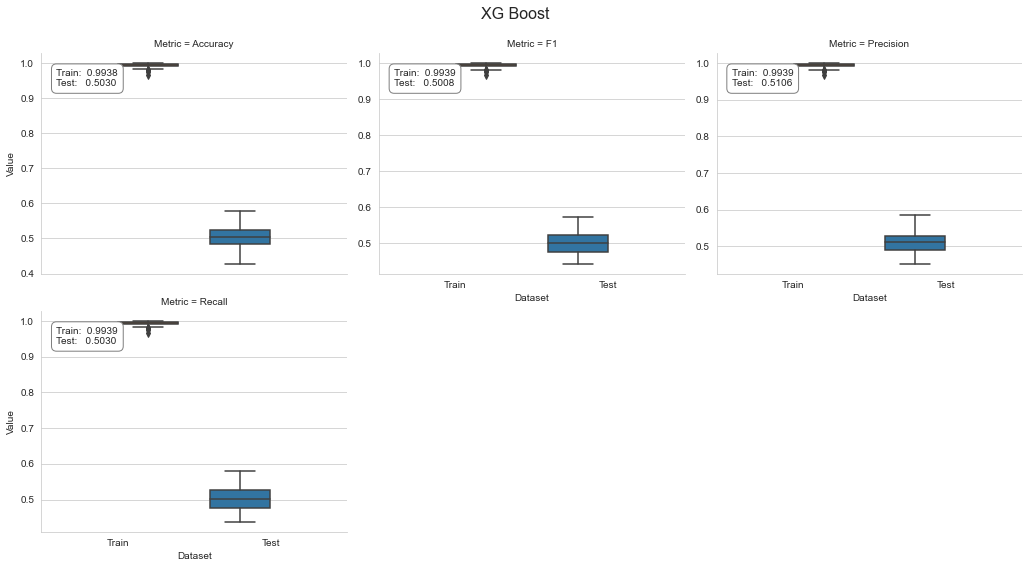

In [56]:
plot_result(xbg_result, model='XG Boost')#, fname=f'figures/{algo}_cv_result')

### Feature Importance

In [57]:
xgb_clf.fit(X=X, y=y)

[22:48:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:48:16] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=0,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.8, max_delta_step=0, max_depth=2,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, silent=False,
              subsample=1, tree_method='gpu_hist', validate_parameters=1,
              verbosity=None)

In [58]:
fi = pd.Series(xgb_clf.feature_importances_, 
               index=X.columns)

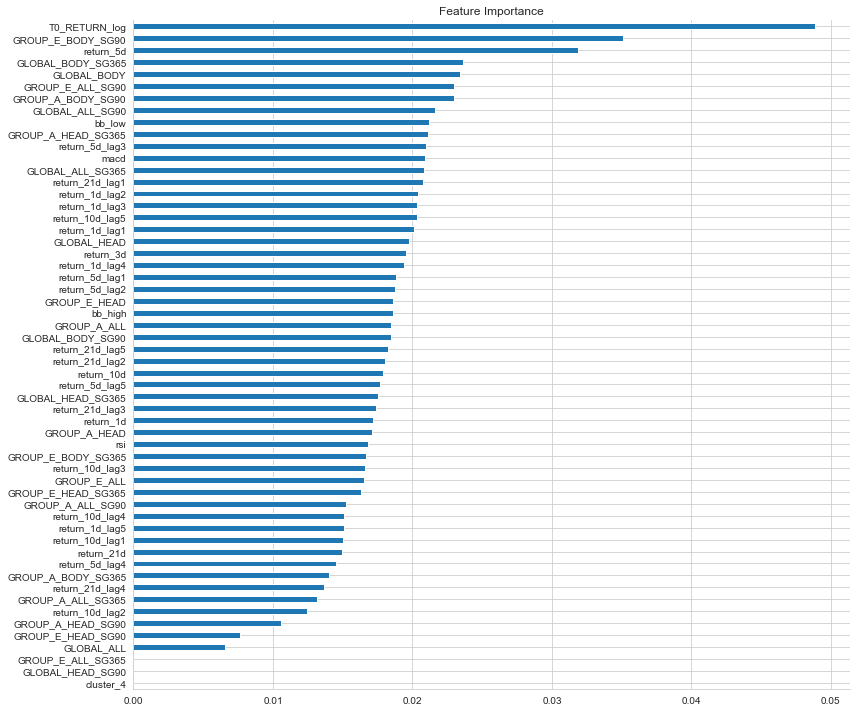

In [59]:
fi.nlargest(70).sort_values().plot.barh(figsize=(12, 10), 
                                        title='Feature Importance')
sns.despine()
plt.tight_layout();

In [60]:
X

GLOBAL_ALL  GLOBAL_HEAD  GLOBAL_BODY  \
RP_ENTITY_ID DATE                                               
14BA06       2010-01-06      -0.570       -0.570          nan   
             2010-01-11      -0.580       -0.580          nan   
             2010-01-22       0.010        0.010        0.010   
             2010-01-25       0.650        0.650        0.650   
             2010-01-26       0.532        0.650        0.449   
...                             ...          ...          ...   
FE89E0       2016-12-15       0.264          nan        0.264   
             2016-12-22       0.237        0.000        0.317   
             2016-12-23       0.180        0.180          nan   
             2016-12-27       0.381          nan        0.381   
             2016-12-29       0.142          nan        0.142   

                         GLOBAL_ALL_SG90  GLOBAL_HEAD_SG90  GLOBAL_BODY_SG90  \
RP_ENTITY_ID DATE                                                              
14BA06       2010-01-06           -0.570            -0.570               nan   
             2010-01-11           -0.580            -0.580               nan   
             2010-01-22            0.010             0.010               nan   
             2010-01-25            0.650             0.650               nan   
             2010-01-26            0.415             0.650             0.180   
...                                  ...               ...               ...   
FE89E0       2016-12-15            0.262               nan             0.262   
             2016-12-22            0.305               nan             0.305   
             2016-12-23              nan               nan               nan   
             2016-12-27            0.458               nan             0.458   
             2016-12-29            0.383               nan             0.383   

                         GLOBAL_ALL_SG365  GLOBAL_HEAD_SG365  \
RP_ENTITY_ID DATE                                              
14BA06       2010-01-06            -0.570             -0.570   
             2010-01-11            -0.580             -0.580   
             2010-01-22             0.010              0.010   
             2010-01-25             0.650              0.650   
             2010-01-26             0.415              0.650   
...                                   ...                ...   
FE89E0       2016-12-15             0.262                nan   
             2016-12-22             0.305                nan   
             2016-12-23               nan                nan   
             2016-12-27             0.458                nan   
             2016-12-29             0.383                nan   

                         GLOBAL_BODY_SG365  GROUP_A_ALL  GROUP_A_HEAD  \
RP_ENTITY_ID DATE                                                       
14BA06       2010-01-06                nan          nan           nan   
             2010-01-11                nan       -0.580        -0.580   
             2010-01-22                nan        0.010         0.010   
             2010-01-25                nan          nan           nan   
             2010-01-26              0.180          nan           nan   
...                                    ...          ...           ...   
FE89E0       2016-12-15              0.262        0.310           nan   
             2016-12-22              0.305        0.170         0.000   
             2016-12-23                nan          nan           nan   
             2016-12-27              0.458        0.407           nan   
             2016-12-29              0.383       -0.020           nan   

                         GROUP_A_ALL_SG90  GROUP_A_HEAD_SG90  \
RP_ENTITY_ID DATE                                              
14BA06       2010-01-06               nan                nan   
             2010-01-11            -0.580             -0.580   
             2010-01-22             0.010              0.010   
             2010-01-25            

In [61]:
# import torch
# torch.cuda.empty_cache()

___
# <a id =7> </a> **7. Backtest on unseen data**
___

In [62]:
# 1474,   5186,  10215,  11778,  14227,  16018,  18601,  25403,
#              26595,  42064,  44821,  49633,  51869,  54260,  56166,  59882,
#              64920,  67587,  71073,  74646,  76492,  91192,  96224, 103593,
#             106685, 115576, 116802, 117717, 120968, 126638, 128898, 131391,
#             134687, 144326, 145843, 157319, 165871, 169540, 170442, 173847,
#             176930, 179465, 185455, 195842, 199120, 200395, 208028, 216140,
#             220251, 222407, 224629, 227503, 229526, 233314, 239153, 239955,
#             240741, 247996, 253338, 256341, 258702, 264921, 272963, 277364,
#             280791, 289231, 290124, 291688, 299978, 302323, 303093, 305154,
#             313302, 314740, 318592, 321560, 322320]


nbinx = [1440,   1441,   3027,   3028,   3029,   5085,   5086,   5087,
              5088,   5982,
            313840, 315184, 315185, 315186, 315187, 315923, 315924, 317058,
            317059, 317060]
# [  5064,  13907,  14655,  15657,  19202,  26021,  28116,  28932,
#              32100,  37910,  41177,  43870,  48601,  50801,  53163,  55029,
#              58681,  60636,  61660,  66198,  67207,  68313,  72327,  73913,
#              74922,  75769,  78738,  87729,  89328,  91483,  94263,  96671,
#              97557,  99149, 104565, 106995, 108576, 110574, 114475, 115381,
#             124120, 125580, 126337, 128776, 130699, 139274, 141496, 151181,
#             154228, 155305, 156992, 158823, 160037, 162593, 165328, 170428,
#             173471, 176833, 178013, 179068, 189032, 192015, 192883, 194388,
#             196447, 203959, 209415, 211961, 215978, 218980, 223085, 226019,
#             228780, 233129, 239845, 241147, 242321, 243140, 246642, 248337,
#             251304, 255287, 256461, 263345, 267621, 268513, 271105, 274069,
#             278040, 278785, 285940, 294085, 299152, 300101, 302584, 308505,
#             312272, 313827]

In [63]:
df_i.reset_index().iloc[nbinx,:].head(60)

IndexError: positional indexers are out-of-bounds

In [64]:
i = 0
for train_idx, test_idx in cv.split(X=X):
    train = X.iloc[train_idx]
    train_dates = train.index.get_level_values('DATE')
    test = X.iloc[test_idx]
    test_dates = test.index.get_level_values('DATE')
    df = train.reset_index().append(test.reset_index())
    n = len(df)
    assert n== len(df.drop_duplicates())
    print(train.groupby(level='RP_ENTITY_ID').size().value_counts().index[0],
          train_dates.min().date(), train_dates.max().date(),
          test.groupby(level='RP_ENTITY_ID').size().value_counts().index[0],
          test_dates.min().date(), test_dates.max().date())
    i += 1
    if i == 10:
        break

960 Int64Index([  666,   667,   668,   669,   670,   671,   672,   673,   674,
              675,
            ...
            19130, 19131, 19132, 19133, 19134, 19135, 19136, 19137, 19138,
            19139],
           dtype='int64', length=960) 286 Int64Index([  702,   703,   704,   705,   706,   707,   708,   709,   710,
              711,
            ...
            19140, 19141, 19142, 19143, 19144, 19145, 19146, 19147, 19148,
            19149],
           dtype='int64', length=286)
48 2016-08-17 2016-11-30 14 2016-12-01 2016-12-30
1025 Int64Index([  652,   653,   654,   655,   656,   657,   658,   659,   660,
              661,
            ...
            19113, 19114, 19115, 19116, 19117, 19118, 19119, 19120, 19121,
            19122],
           dtype='int64', length=1025) 268 Int64Index([  692,   693,   694,   695,   696,   697,   698,   699,   700,
              701,
            ...
            19130, 19131, 19132, 19133, 19134, 19135, 19136, 19137, 19138,
            19139]

In [ ]:
y